In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import time
import pandas as pd
from subprocess import Popen,PIPE
import sys
from scipy.signal import savgol_filter
from multiprocessing import Process

'''
1. make like the energyTemp stuff
2. run program from python
3. run more than just one instance in parrall to save time i guess
4. 2 or 4 processes need to give the machine more resouces
'''
#Data location
basicDataLocation = '/home/cm/CLionProjects/MDCode/AData/Clusters'

#Natur Konstants
boltzmannConstant = 1.380649e-23 
electronVolt = 1.602176634e-19
boltzmannElectronVolt  = boltzmannConstant/electronVolt


#most basic file to list function
def readDataFromFile(fileLocation):
    #open file
    file = open(fileLocation,'r')
    #read from the file
    text = file.readlines()
    returnValue = []
    for line in text:
        returnValue.append(float(line[:-1]))
    
    file.close()
    return returnValue

#those functions just save the data and then look at it
def dataPlotterEnergyTemperatur(layerID):
    #file Locations
    energyFileLocation = basicDataLocation + "/energy" + str(layerID) + ".txt"
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/temperaturEnergyCurve" + str(layerID) + ".png"
    
    #get Energy
    energy = readDataFromFile(energyFileLocation)

    #get Temperatur
    temperatur = readDataFromFile(temperaturFileLocation)
    
    #filter 
    df1 = pd.DataFrame(dict(x=energy))
    energyFiltered = df1[["x"]].apply(savgol_filter, window_length=3, polyorder=2)
    
    df2 = pd.DataFrame(dict(x=temperatur))
    temperaturFiltered = df2[["x"]].apply(savgol_filter, window_length=3, polyorder=2)

    #plot
    labelX = "Temperatur [K]"
    labelY = "Energy [eV]"
    plotNormal(temperaturFiltered, energyFiltered, labelX, labelY, imageSafeLocation)
    
    return imageSafeLocation
    
def dataPlotterKineticEnergy(layerID):
    #File locations
    fileLocation = basicDataLocation + "/kineticEnergy" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/kineticEnergyCurve" + str(layerID) + ".png"
    
    #get the kinetic Energy
    kineticEnergy = readDataFromFile(fileLocation)
    
    #create time array
    timestep = 1
    lenght = len(kineticEnergy)
    time = np.arange(start = 0, stop = timestep*lenght, step = timestep)
    
    #filter data couse this looks way to messy
    df = pd.DataFrame(dict(x=kineticEnergy))
    kineticEnergyFiltered = df[["x"]].apply(savgol_filter, window_length=1001, polyorder=2)

    #plot
    plt.rcParams['figure.figsize'] = [16,9]  
    fig, ax = plt.subplots()
    ax.plot(time,kineticEnergy)
    ax.plot(kineticEnergyFiltered,'r')
    ax.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
    ax.grid(which = 'minor', color = '#EEEEEE', linewidth = 0.5)
    ax.minorticks_on()
    plt.xlabel("Time [fs]")
    plt.ylabel("Energy [eV]")
    plt.savefig(imageSafeLocation)
    plt.show()
    return imageSafeLocation
    

def functionCall(layerID):
    #file locations
    programbasePath = "/home/cm/CLionProjects/MoleDymCode/cmake-build-release/"
    programName = "myproject"
    programCall = programbasePath + programName

    #call the c++ program 
    process = Popen([programCall,str(layerID)],stdout = PIPE, stderr= PIPE)
    Popen.wait(process)
    stdout, stderr = process.communicate()
    print(stdout)
    print(stderr)

def combinedFunction(layerID):
    print("Working on Cluster " + str(layerID) + "\n")
    functionCall(layerID)
    #dataPlotterKineticEnergy(layerID)
    #dataPlotterEnergyTemperatur(layerID)

def plotter():
    for layerID in range(14-3+1):
        dataPlotterKineticEnergy(layerID+3)
        #dataPlotterEnergyTemperatur(layerID+3)
        dataPlotterPotentialEnergyTemperatur(layerID+3)
        dataPlotterDiffEnergyTemperatur(layerID+3)
    
def callInParralel(valueArray):
    for v in valueArray:
        combinedFunction(v)
        #print("Working on Cluster " + str(v)+"\n")

def dataMaker():
    start = time.time()        
    #create Patterns
    '''
    #standard
    callPattern1 = np.array([3,4,12])
    callPattern2 = np.array([5,6,11])
    callPattern3 = np.array([8,9])
    callPattern4 = np.array([7,10])
    callPattern5 = np.array([13])
    callPattern6 = np.array([14])
    '''
    #finer for some
    callPattern1 = np.array([5])
    callPattern2 = np.array([6])
    callPattern3 = np.array([8])
    callPattern4 = np.array([7])
    callPattern5 = np.array([3])
    callPattern6 = np.array([4])
    #create Processes
    process1 = Process(target = callInParralel, args =(callPattern1,))
    process2 = Process(target = callInParralel, args =(callPattern2,))
    process3 = Process(target = callInParralel, args =(callPattern3,))
    process4 = Process(target = callInParralel, args =(callPattern4,))
    process5 = Process(target = callInParralel, args =(callPattern5,))
    process6 = Process(target = callInParralel, args =(callPattern6,))

    #start processes
    process1.start()
    process2.start()
    process3.start()
    process4.start()
    process5.start()
    process6.start()

    #wait till end
    process1.join()
    process2.join()
    process3.join()
    process4.join()
    process5.join()
    process6.join()
    
    #
    end = time.time()
    print("Done in")
    print(end - start)

def readClusterSizes(layerID):
    #reads the first line form the clusters which contains the number of Atoms
    clusterFile = basicDataLocation + "/cluster" + str(layerID) + ".xyz"
    with open(clusterFile) as f:
        number = f.readlines()[0].rstrip()
        
    return number
     
def calculateKineticEnergyBack(layerID):
    #data location
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    
    #read from file
    temperatur = readDataFromFile(temperaturFileLocation)
    
    #calculation    
    nbAtoms = float(readClusterSizes(layerID))
    kineticEnergy = 1.5 * boltzmannElectronVolt * np.array(temperatur) * nbAtoms
    
    return kineticEnergy

def dataPlotterPotentialEnergyTemperatur(layerID):
    #TLDR i can not read
    
    #data location
    energyFileLocation = basicDataLocation + "/energy" + str(layerID) + ".txt"
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    imageSafeLocation = basicDataLocation + "/temperaturPotentialEnergyCurve" + str(layerID) + ".png"
    
    #read from file
    energy = readDataFromFile(energyFileLocation)
    temperatur = readDataFromFile(temperaturFileLocation)
    
    #potential Energy
    potentialEnergy = np.array(energy) - calculateKineticEnergyBack(layerID)
    
    #filter 
    df1 = pd.DataFrame(dict(x=potentialEnergy))
    energyFiltered = df1[["x"]].apply(savgol_filter, window_length=9, polyorder=2)
    
    df2 = pd.DataFrame(dict(x=temperatur))
    temperaturFiltered = df2[["x"]].apply(savgol_filter, window_length=9, polyorder=2)
    
    #plot
    labelX = "Temperatur [K]"
    labelY = "Energy [eV]"
    plotNormal(temperaturFiltered, energyFiltered, labelX, labelY, imageSafeLocation)
    return imageSafeLocation

def getGradForCapacity(layerID):
    energyFileLocation = basicDataLocation + "/energy" + str(layerID) + ".txt"
    temperaturFileLocation = basicDataLocation + "/temperatur" + str(layerID) + ".txt"
    
    #get Energy
    energy = readDataFromFile(energyFileLocation)
    
    #get Temperatur
    temperatur = readDataFromFile(temperaturFileLocation)
    
    #####
    grad = np.gradient(energy)/np.gradient(temperatur)
    
    return np.median(grad)

#melting of the cluster
#was just done by hand way easier
def clusterVsMelting():
    imageSafeLocation = basicDataLocation + "/clusterVsMelting" + ".png"
    
    #data by hand
    meltingPoints = np.array([600,710,745,775,800,825,850,865,870,880,900,910])
    
    #sizes
    clusterSize = []
    for i in range(len(meltingPoints)):
        clusterSize.append(readClusterSizes(i+3))
    
    #plot
    labelX = "Clustersize"
    labelY = "Meltingpoint [K]"
    plotNormal(clusterSize,meltingPoints, labelX, labelY, imageSafeLocation)
    return imageSafeLocation
    
def clusterVSHeatCapacity():
    imageSafeLocation = basicDataLocation + "/clusterVsCapacity" + ".png"
    #grad
    grad = []
    
    #sizes
    clusterSize = []
    for i in range(12):
        clusterSize.append(readClusterSizes(i+3))
        grad.append(getGradForCapacity(i+3))
        
    #plot
    labelX = "Clustersize"
    labelY = "Heat Capacity [ev/K]"
    plotNormal(clusterSize,grad, labelX, labelY, imageSafeLocation)
    return imageSafeLocation
    
def clusterVsLatentHeat():
    imageSafeLocation = basicDataLocation + "/clusterVsLatentHeat" + ".png"
    
    #data by hand
    latentHeat = np.array([4,18,30,60,100,120,175,200,250,400,600,800])
    #sizes
    clusterSize = []
    for i in range(len(latentHeat)):
        clusterSize.append(readClusterSizes(i+3))
    
    # 
    value = []
    c = np.array(clusterSize)
    for i in range(len(latentHeat)):
        value.append(latentHeat[i].astype('float')/c[i].astype('float'))
        
    #plot
    labelX = "Clustersize"
    labelY = "Latent Heat [eV]"
    plotNormal(clusterSize,latentHeat, labelX, labelY, imageSafeLocation)
    return imageSafeLocation

def plotNormal(datum1, datum2, labelX, labelY, imageSafeLocation):
    plt.rcParams['figure.figsize'] = [16,9] 
    plt.rc('font', size = 15)
    fig, ax = plt.subplots()
    ax.plot(datum1,datum2)
    ax.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
    ax.grid(which = 'minor', color = '#EEEEEE', linewidth = 0.5)
    ax.minorticks_on()
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.savefig(imageSafeLocation)
    plt.show()
    

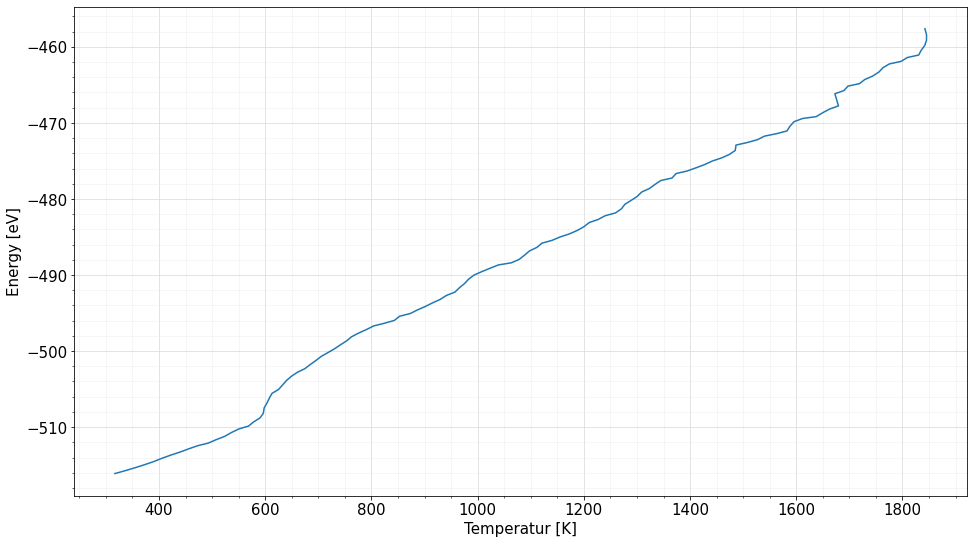

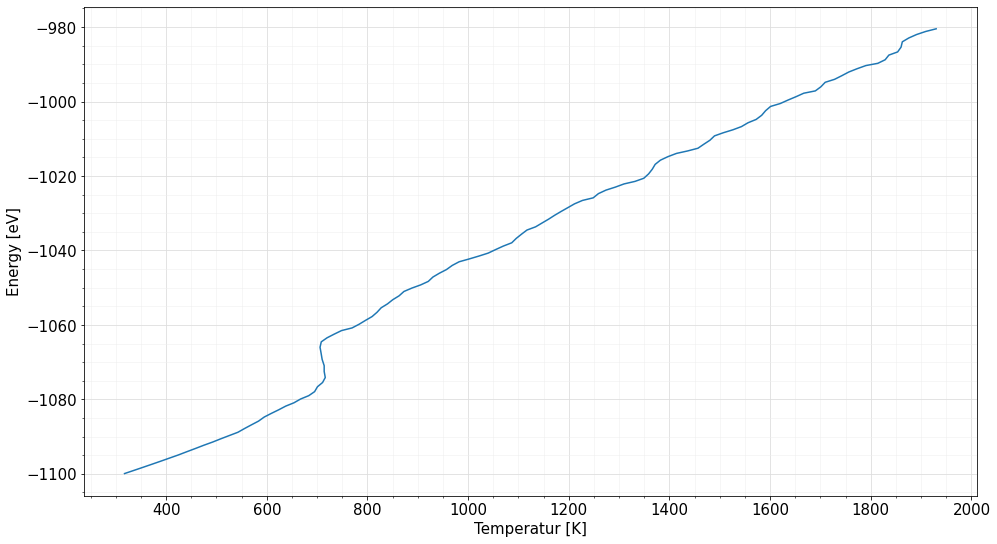

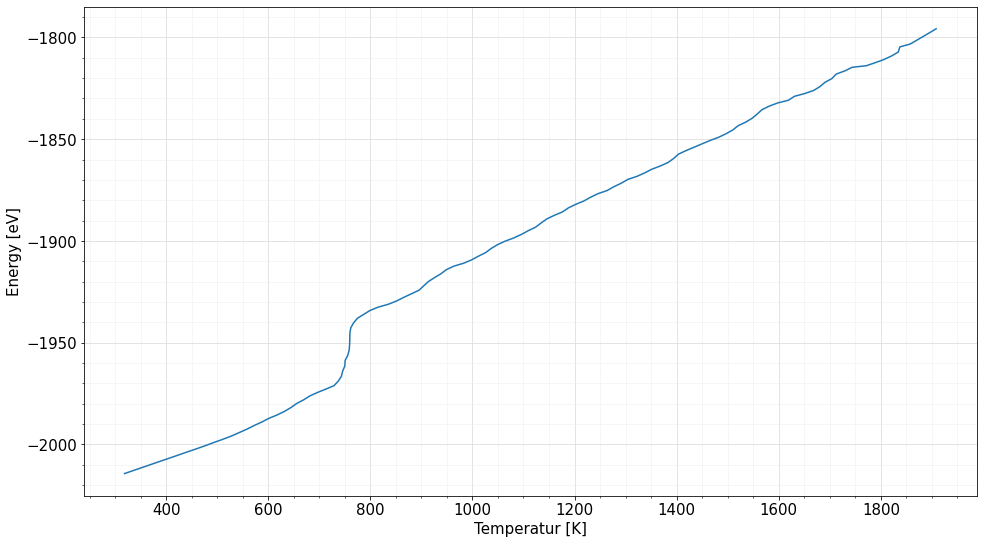

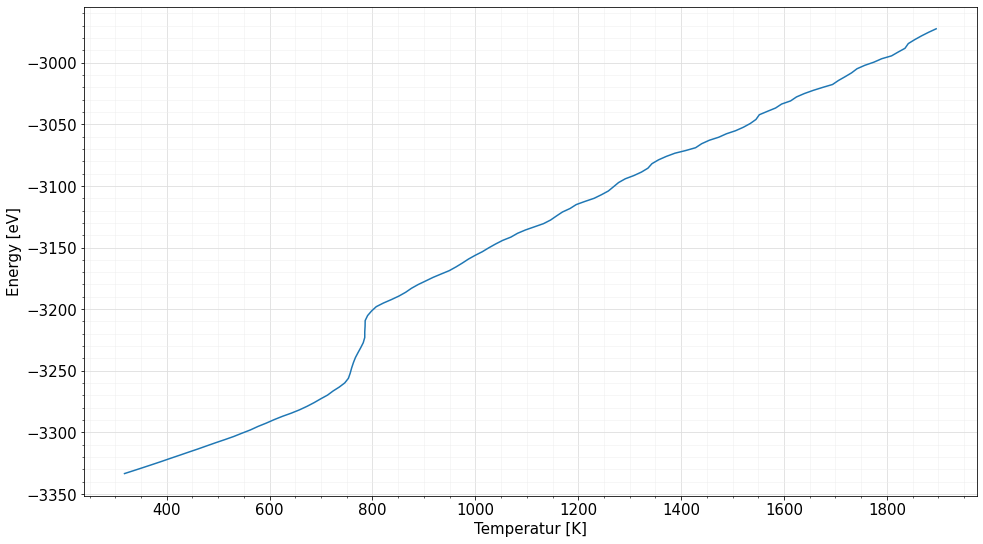

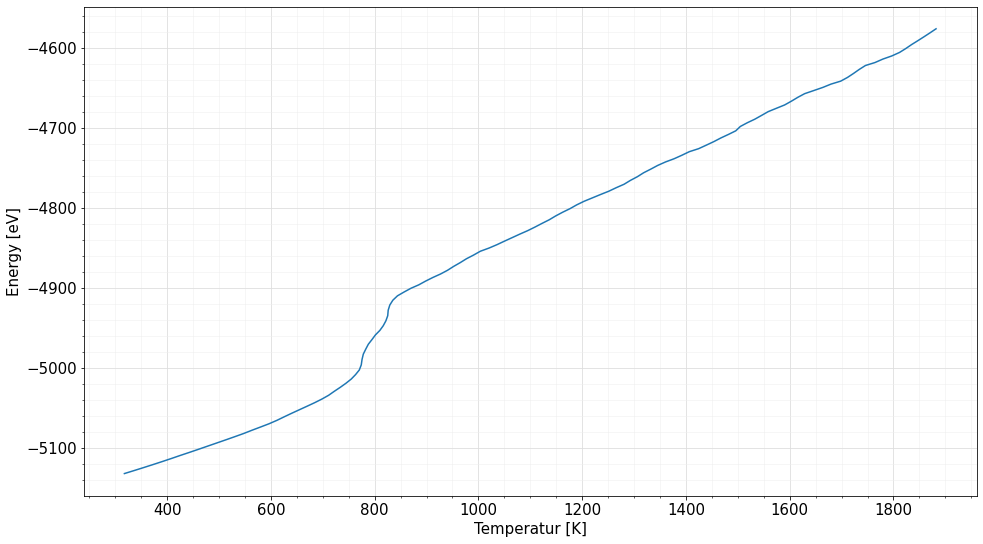

In [ ]:
#tex generator for easy use lol
backSlash = " \n"

def texGeneratorFigures():
    energyFileLocation = basicDataLocation + "/texFigures" + ".tex"
    
    #open file
    file = open(energyFileLocation,'w')
    
    #work
    for layerID in range(14-3+1):
        file.write(texGenerator(layerID+3))
    
    file.write(vsClusterFigures())
    #close file
    file.close()

def texGenerator(layerID):
    '''
    \begin{figure}[!h]
        \begin{center}
            \includegraphics[scale=1]{Figure/plotAtomTimes.png}
        \end{center}
        \caption[Simulationtime]{Simulationtime from 8 to 192 Atoms }
        \label{PlotAtomTimes}
    \end{figure}
    '''
    #return String that can be written to the 
    returnString = "% Figures for " + readClusterSizes(layerID) + " Atoms" + backSlash 
    
    '''
    #plot time to kin
    fileLocation = dataPlotterKineticEnergy(layerID)
    titleString = "Gold Cluster Simulation with " + readClusterSizes(layerID) + " Atoms" 
    label = "GoldClusterSimulationKineticTime" + readClusterSizes(layerID) 
    returnString += figurePart(fileLocation, titleString, label)
    
    '''
    
    #2 plot temperatur to energy
    fileLocation = dataPlotterPotentialEnergyTemperatur(layerID)
    titleString = "Gold Cluster Simulation with " + readClusterSizes(layerID) + " Atoms"
    label = "GoldClusterSimulationTemperaturEnergy" + readClusterSizes(layerID)
    returnString += figurePart(fileLocation, titleString, label)
    
    #
    return returnString
    
def vsClusterFigures():
    # the three extra ones
    #cluster vs Melting
    returnString = "% vsCluster Figures"+ backSlash
    fileLocation = clusterVsMelting()
    titleString = "The size of the Cluster vs it's melting point"
    label = "clusterVsMelting"
    returnString += figurePart(fileLocation, titleString, label)
    
    #clusterVsCapacity
    fileLocation = clusterVSHeatCapacity()
    titleString = "The size of the Cluster vs the heat capacity"
    label = "clusterVsCapacity"
    returnString += figurePart(fileLocation, titleString, label)
    
    #clusterVsLatentHeat
    fileLocation = clusterVsLatentHeat()
    titleString = "The size of the Cluster vs Latent Heat"
    label = "clusterVsLatentHeat"
    returnString += figurePart(fileLocation, titleString, label)
    return returnString

def figurePart(fileLocation, titleString, label):
    returnString = ""
    returnString += "\\begin{figure}[!h]" + backSlash
    returnString += "    \\begin{center}" + backSlash
    returnString += "        \includegraphics[scale=1.15]{" + fileLocation + "}"+ backSlash
    returnString += "    \end{center}"+ backSlash
    returnString += "    \caption[" + titleString + "]{" +titleString +"}" + backSlash
    returnString += "    \label{"+ label  + "}" + backSlash
    returnString += "\end{figure}"+ backSlash
    returnString += backSlash
    return returnString


texGeneratorFigures()